In [126]:
import matplotlib.pyplot as plt
import torch
from typing import List

import nnts
import nnts.data
import nnts.experiments
import nnts.models
import nnts.torch.data.preprocessing as preprocessing
import nnts.torch.models
import nnts.torch.models.trainers as trainers
import nnts.metrics
import nnts.torch.data
import nnts.torch.data.datasets
import nnts.loggers
import covs 

import seaborn as sns
sns.set()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [212]:
df_orig, metadata = nnts.data.load("traffic")
params = nnts.models.Hyperparams()
splitter = nnts.data.PandasSplitter()
model_name = "base-lstm"
PATH = f"results/{model_name}/{metadata.dataset}"

In [213]:
scenario_list: List[nnts.experiments.CovariateScenario] = []
# Models for full forecast horizon with covariates
scenario_list.append( 
    nnts.experiments.CovariateScenario(
        metadata.prediction_length, 0, covariates=0
    )
)
for covariates in [1]:
    for error in covs.errors[metadata.dataset]:
        scenario_list.append( 
            nnts.experiments.CovariateScenario(
                metadata.prediction_length, error, covariates=covariates
            )
        )


In [214]:
def save_results(y_hat, y, name):
    torch.save(y_hat, f"{PATH}/{name}_y_hat.pt")
    torch.save(y, f"{PATH}/{name}_y.pt")


def save_metrics(metrics, name):
    torch.save(metrics, f"{PATH}/{name}_metrics.pt")

def load_metrics(name):
    return torch.load(f"{PATH}/{name}_metrics.pt")


def calculate_forecast_horizon_metrics(y_hat, y, metadata, metric="mae"):
    forecast_horizon_metrics = []
    for i in range(1, metadata.prediction_length+1):
        metrics = nnts.metrics.calc_metrics(
            y[:, :i, :], y_hat[:, :i, :], metadata.freq, metadata.seasonality
        )
        forecast_horizon_metrics.append(metrics[metric])
    return forecast_horizon_metrics

In [215]:
#metadata.context_length = metadata.prediction_length * 8 + 1 if metadata.dataset == "traffic" else metadata.prediction_length * 3 +1
metadata.seasonality = 8 if metadata.dataset == "traffic" else metadata.seasonality

In [216]:
for scenario in scenario_list:
    nnts.torch.data.datasets.seed_everything(scenario.seed)
    df, scenario = covs.prepare(df_orig.copy(), scenario)
    split_data = splitter.split(df, metadata)
    _, _, test_dl = nnts.data.map_to_dataloaders(
        split_data,
        metadata,
        scenario,
        params,
        nnts.torch.data.TorchTimeseriesDataLoaderFactory(),
    )
    net = nnts.torch.models.BaseLSTM(
        nnts.torch.models.LinearModel,
        params,
        preprocessing.masked_mean_abs_scaling,
        scenario.covariates+1,
        #metadata.seasonality,
    )
    best_state_dict = torch.load(
        f"{PATH}/{scenario.name}.pt"
    )
    net.load_state_dict(best_state_dict)
    evaluator = nnts.torch.models.trainers.TorchEvaluator(net)
    y_hat, y  = evaluator.evaluate(
        test_dl, scenario.prediction_length, metadata.context_length
    )
    test_metrics = nnts.metrics.calc_metrics(
        y, y_hat, metadata.freq, metadata.seasonality
    )
    save_results(y_hat, y, scenario.name)
    forecast_horizon_metrics = calculate_forecast_horizon_metrics(
        y_hat, y, metadata, "smape"
    )
    save_metrics(forecast_horizon_metrics, scenario.name)

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


PearsonRResult(statistic=1.0, pvalue=0.0)


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


PearsonRResult(statistic=0.9734762891368408, pvalue=0.0)


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


PearsonRResult(statistic=0.9050352330593034, pvalue=0.0)


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


PearsonRResult(statistic=0.8173705894712557, pvalue=0.0)


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


PearsonRResult(statistic=0.7287625793743431, pvalue=0.0)


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


PearsonRResult(statistic=0.6483279278893316, pvalue=0.0)


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


PearsonRResult(statistic=0.5787754959386153, pvalue=0.0)


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


PearsonRResult(statistic=0.519786682090601, pvalue=0.0)


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


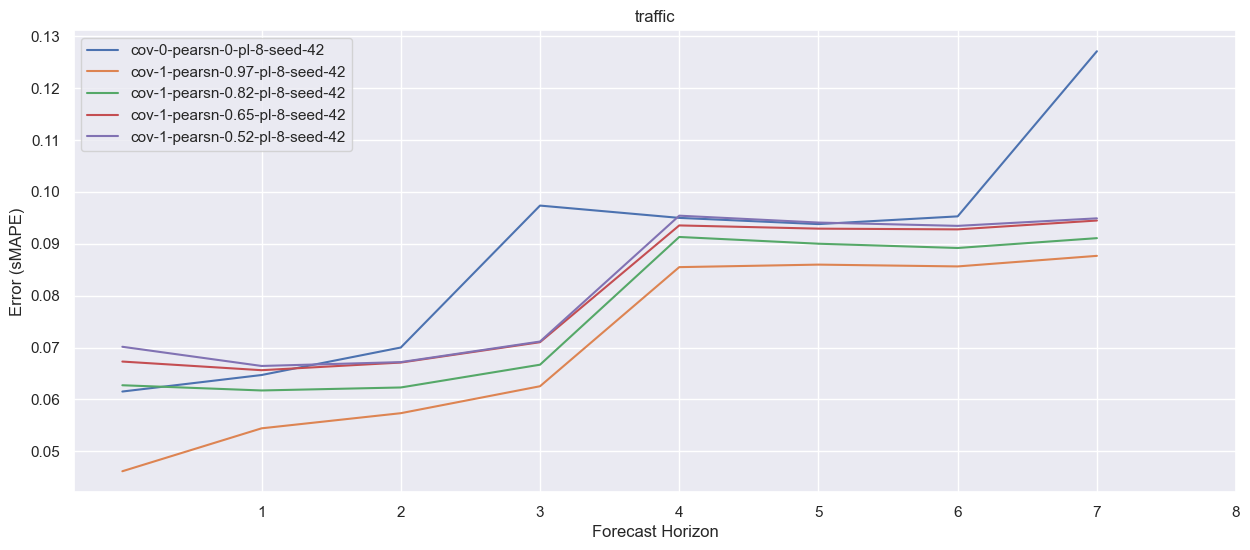

In [225]:
fig, ax = plt.subplots(figsize=(15, 6))

for scenario in scenario_list[::2]:
    forecast_horizon_metrics = load_metrics(scenario.name)
    ax.plot(forecast_horizon_metrics, label=scenario.name)

    # Set labels and legend
#
ax.set_xlim(
    1, len(forecast_horizon_metrics)
)  # Set x-axis limits from 1 to the length of the data
ax.set_xticks(
    range(1, len(forecast_horizon_metrics) + 1)
)  # Set x-axis tick positions from 1 to the length of the data

ax.set_xlabel("Forecast Horizon")
ax.set_ylabel("Error (sMAPE)")
ax.set_title(f"{metadata.dataset}")
ax.legend()
plt.savefig(f"{PATH}/{model_name}-{metadata.dataset}-sMAPE.png")
plt.show()

In [210]:
csv_aggregator = covs.CSVFileAggregator(PATH, "results")
results = csv_aggregator()

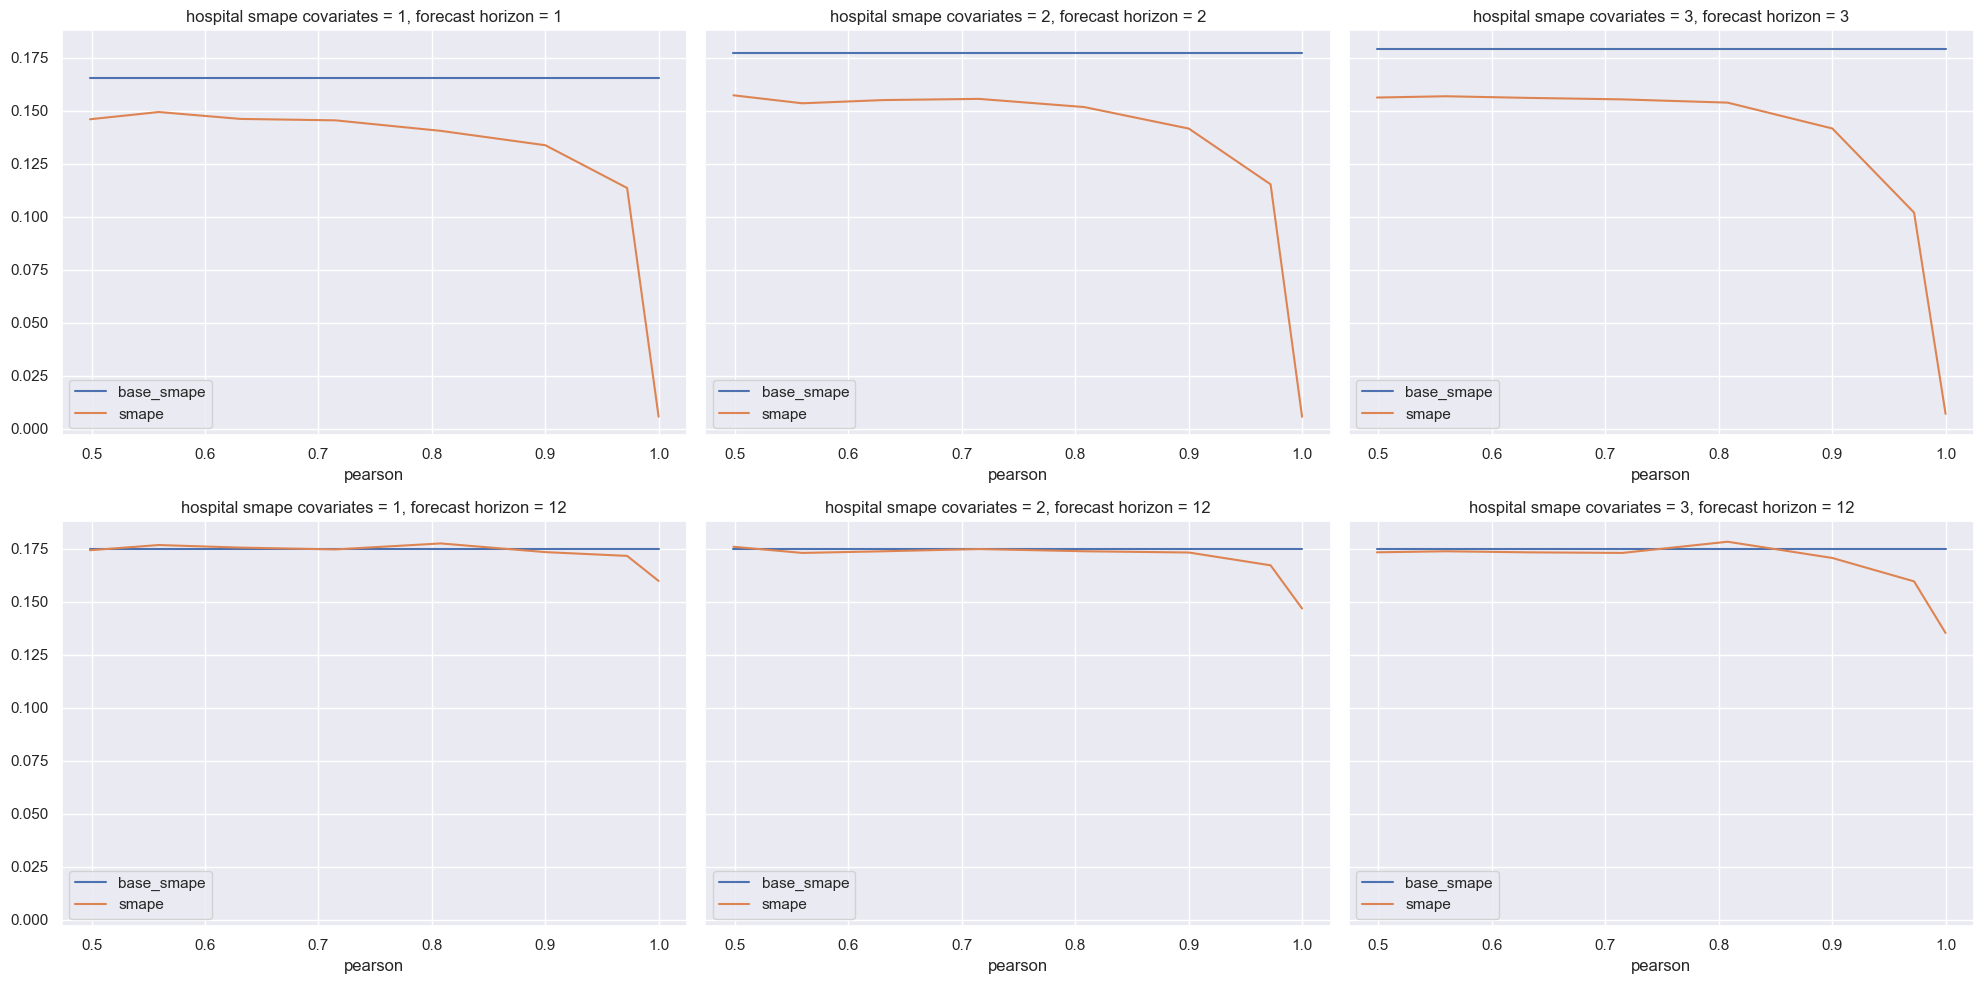

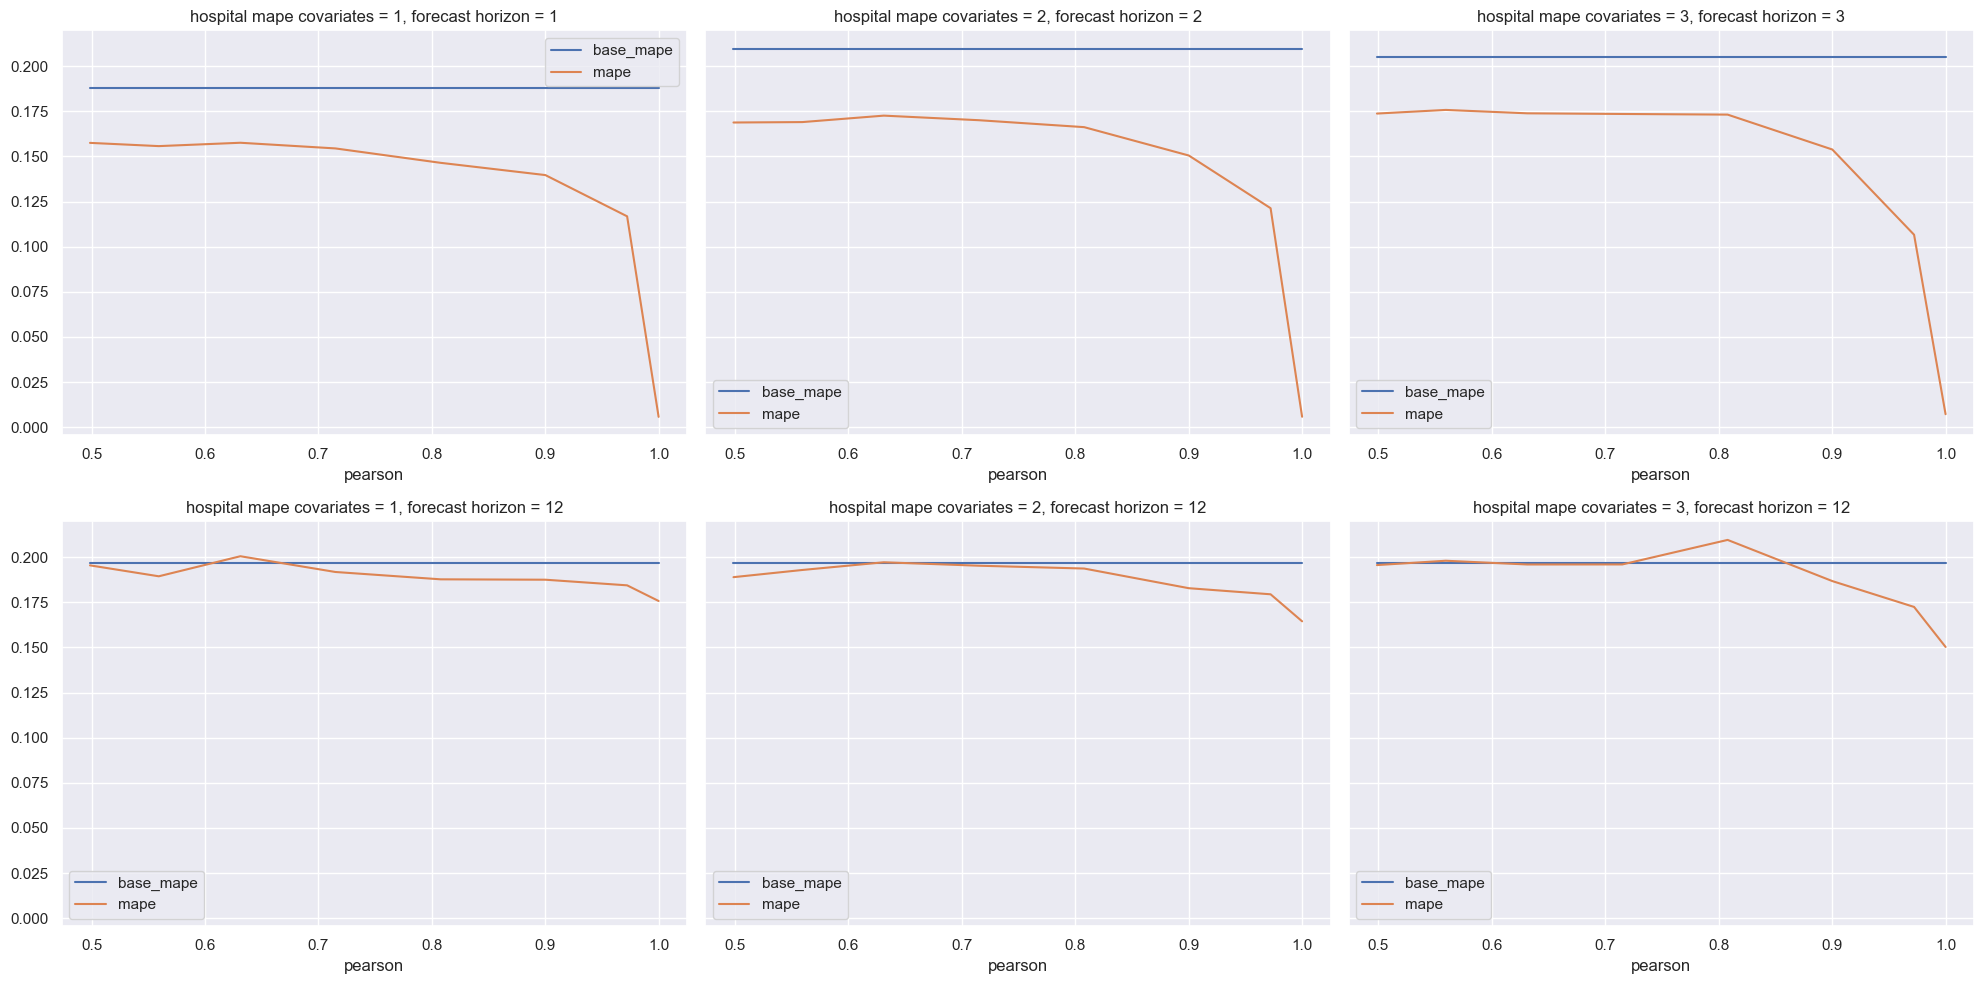

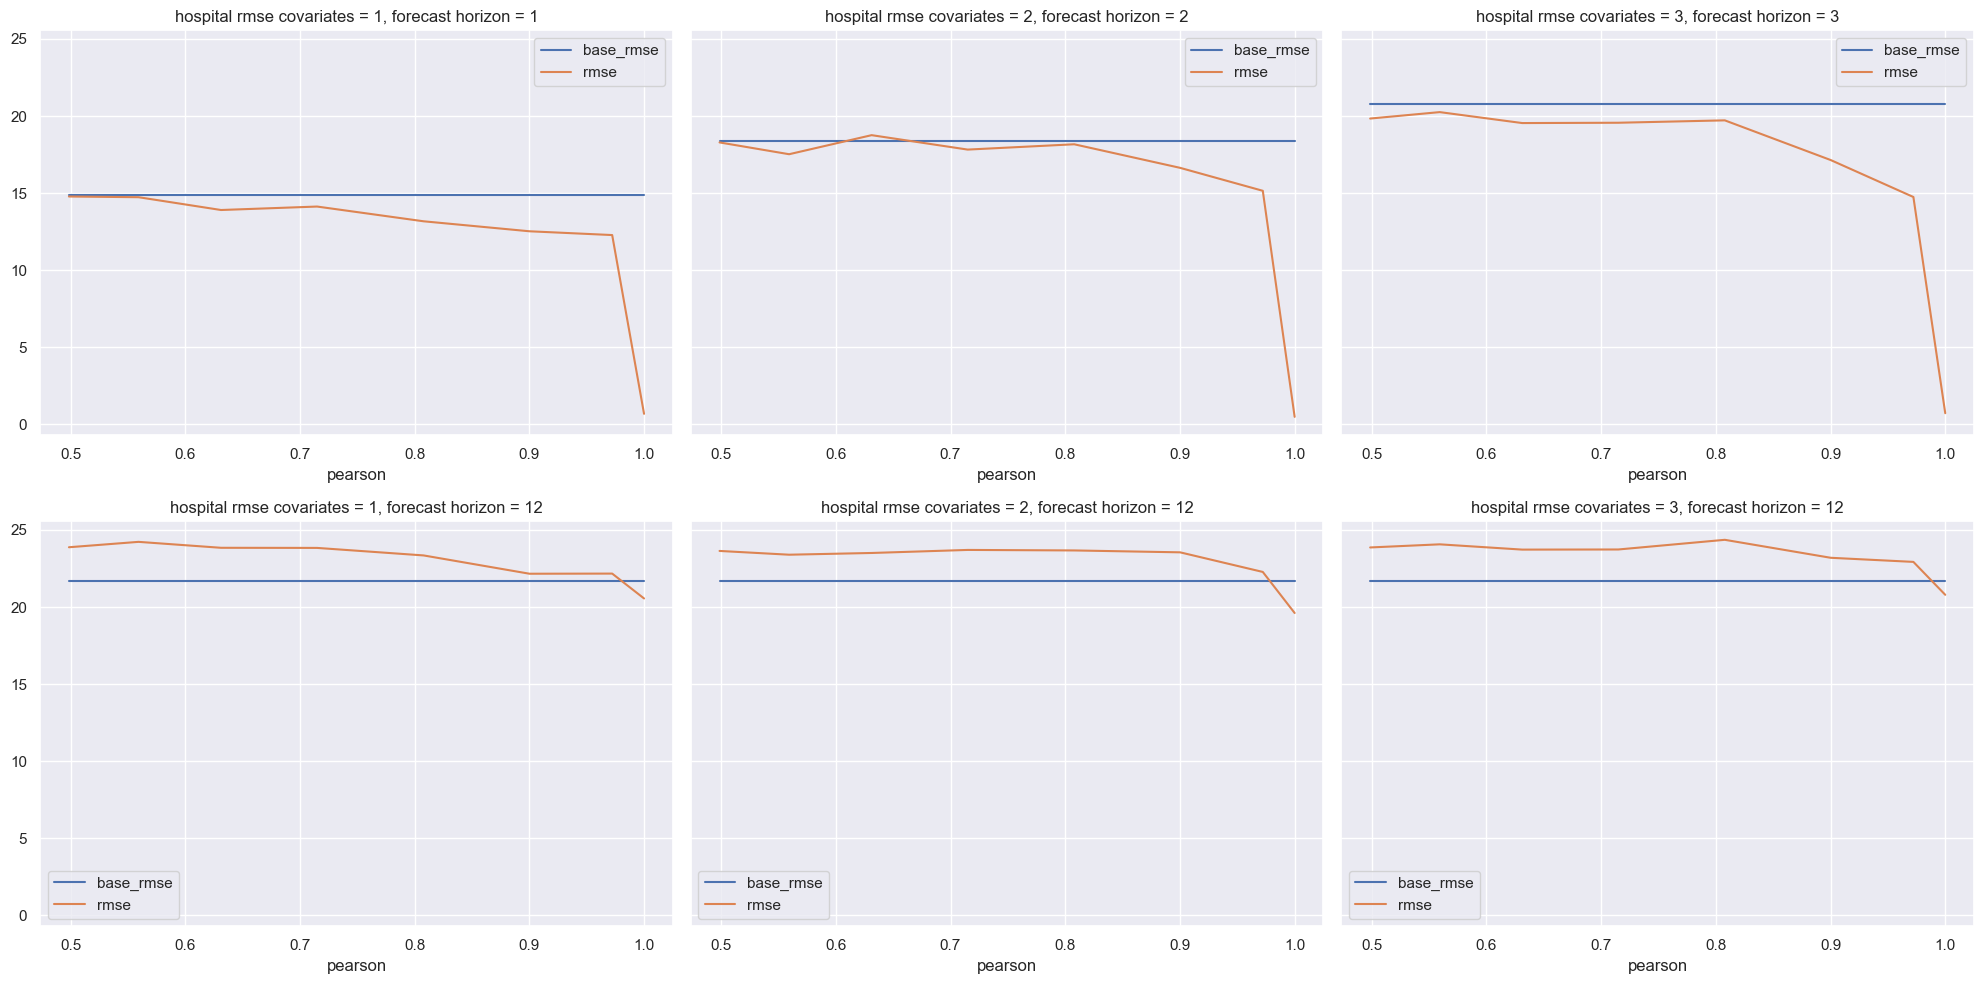

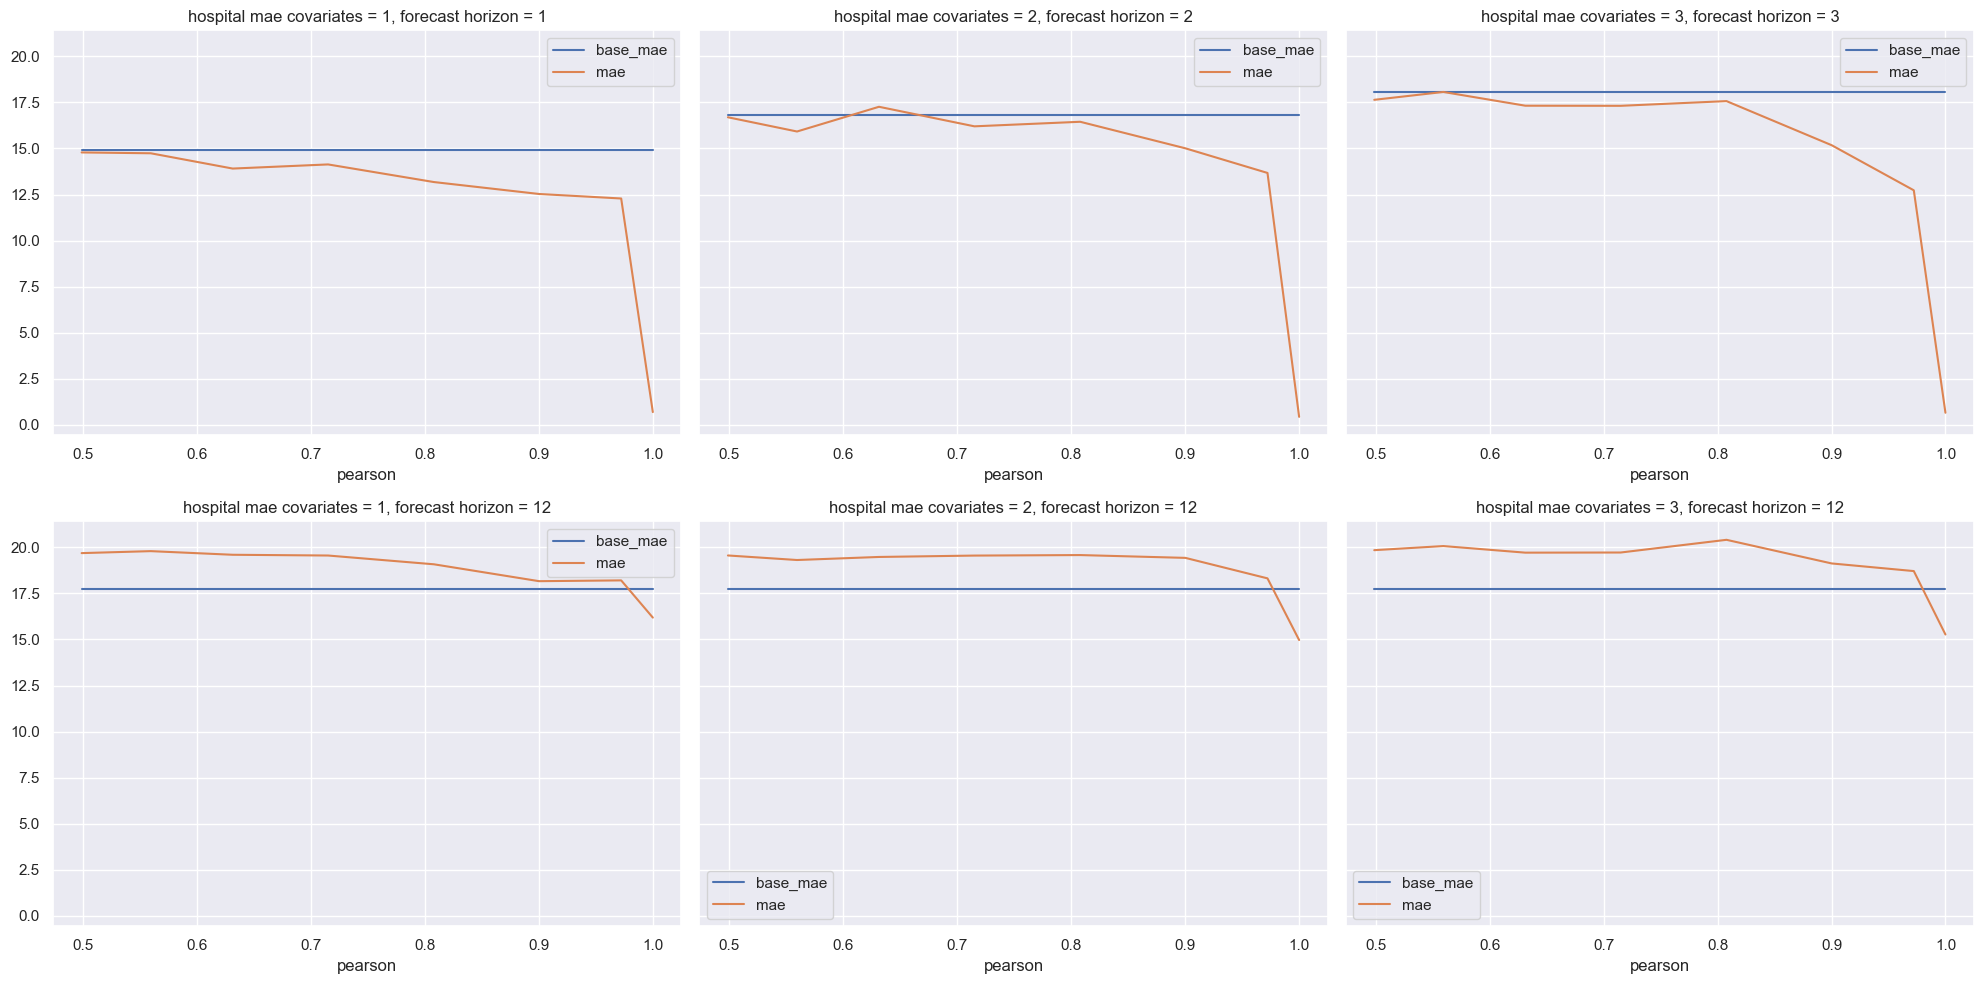

In [211]:
#results = pd.read_csv(f"{PATH}/results.csv")

for metric in ["smape", "mape", "rmse", "mae"]:
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), sharey=True)
    covs.get_chart_data(results, 1, 1, metric).plot(
        kind="line",
        ax=axes[0, 0],
        title=f"{metadata.dataset} {metric} covariates = 1, forecast horizon = 1",
    )
    covs.get_chart_data(results, 2, 2, metric).plot(
        kind="line",
        ax=axes[0, 1],
        title=f"{metadata.dataset} {metric} covariates = 2, forecast horizon = 2",
    )
    covs.get_chart_data(results, 3, 3, metric).plot(
        kind="line",
        ax=axes[0, 2],
        title=f"{metadata.dataset} {metric} covariates = 3, forecast horizon = 3",
    )
    covs.get_chart_data(results, metadata.prediction_length, 1, metric).plot(
        kind="line",
        ax=axes[1, 0],
        title=f"{metadata.dataset} {metric} covariates = 1, forecast horizon = {metadata.prediction_length}",
    )
    covs.get_chart_data(results, metadata.prediction_length, 2, metric).plot(
        kind="line",
        ax=axes[1, 1],
        title=f"{metadata.dataset} {metric} covariates = 2, forecast horizon = {metadata.prediction_length}",
    )
    covs.get_chart_data(results, metadata.prediction_length, 3, metric).plot(
        kind="line",
        ax=axes[1, 2],
        title=f"{metadata.dataset} {metric} covariates = 3, forecast horizon = {metadata.prediction_length}",
    )
    fig.tight_layout()
    fig.savefig(f"{PATH}/{metric}.png")

/Users/garethdavies/Development/workspaces/nnts/projects/covariates/covs.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group["y_hat"][-prediction_length:] = y_hat[i].squeeze()
/Users/garethdavies/Development/workspaces/nnts/projects/covariates/covs.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group["y_hat"][-prediction_length:] = y_hat[i].squeeze()
/Users/garethdavies/Development/workspaces/nnts/projects/covariates/covs.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

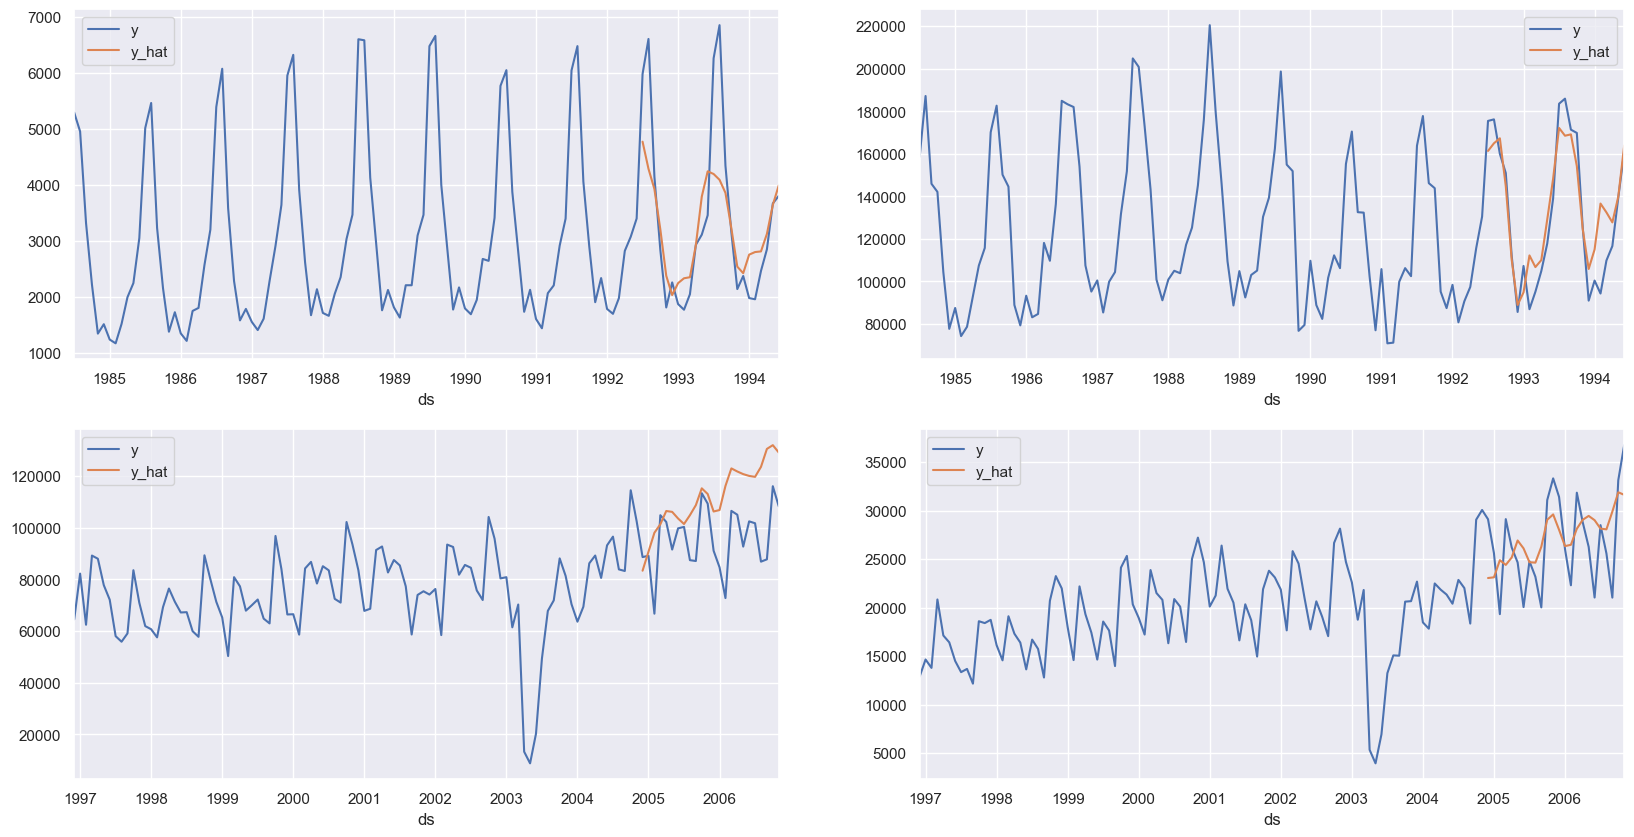

In [135]:
df_list = covs.add_y_hat(df, y_hat, scenario.prediction_length)
sample_preds = covs.plot(df_list, scenario.prediction_length)

In [42]:
results.loc[(results['covariates']==0) & (results['prediction_length']==metadata.prediction_length),['smape', 'mape', 'rmse', 'mae']].mean()

smape      0.212022
mape            inf
rmse     469.076904
mae      287.952765
dtype: float64